In [1]:
#Importing Libraries
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
import pandas as pd
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from scipy import interp
import pickle
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Loading Electronics dataset
pos_list=[]
neg_list=[]
with open("positive.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        pos_list.append(words[i].string.strip('\n'))
    #print(list)
with open("negative.txt") as fp:
    soup=BeautifulSoup(fp)
    words=soup.find_all("review_text")
    for i in range(0,len(words)-1):
        neg_list.append(words[i].string.strip('\n'))

In [3]:
#Loading Electronics dataset
amazondata=pd.read_csv("Amazon Electronics.csv")

In [4]:
amazonlist=[]
for val in amazondata['reviews']:
    amazonlist.append(val)


### Data Cleaning 

In [5]:
df = pd.DataFrame()
stop_words = stopwords.words('english')
porter=PorterStemmer()

def clean_data(data):
    new=[]
    newlist=[]
    for i in data:    
        i = re.sub(r"\'m", " am", i)
        i = re.sub(r"\'ve", " have", i)
        i = re.sub(r"n\'t", " not", i)
        i = re.sub(r"\'re", " are", i)
        i = re.sub(r"\'s", " is", i)
        i = re.sub(r"\'d", " would", i)
        i = re.sub(r"\'ll", " will", i)
        i = re.sub(r"(\n+)", " ", i)
        i=i.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        new.append(i.translate(table))
    for text in new:
        sentence=[]
        word_list=text.split(' ')
        for word in word_list:
            if word not in stop_words and word.isalpha() and len(word)>2:            
                sentence.append(porter.stem(word))
        newlist.append(' '.join(sentence))
    return newlist

cleanpos_list=clean_data(pos_list)
cleanneg_list=clean_data(neg_list)
cleanamazon_list=clean_data(amazonlist)



In [6]:
df_amazon = pd.DataFrame(cleanamazon_list)
df_amazon['sentiment']=amazondata['sentiment']
df_amazon.columns = ['reviews', 'sentiment']  
df_amazon.shape

(4000, 2)

In [7]:
df_pos = pd.DataFrame(cleanpos_list)
df_pos['sentiment'] = np.ones(len(cleanpos_list))
df_pos.columns = ['reviews', 'sentiment']

df_neg = pd.DataFrame(cleanneg_list)
df_neg['sentiment'] = np.zeros(len(cleanneg_list))
df_neg.columns = ['reviews', 'sentiment']

df = df_pos.append(df_neg,ignore_index=True)
finaldf=df.append(df_amazon,ignore_index=True)
print(finaldf.tail())
print(finaldf.shape)

                                                reviews  sentiment
5993                  warn wear big chanc hear one near        1.0
5994  nice lightweight pluse tradit durabl lightweig...        1.0
5995     seem work fine rememb take tini rubber cap end        1.0
5996  hand easiest best made full motion mount bough...        1.0
5997                          great price great qualiti        1.0
(5998, 2)


### Tokenization

In [9]:

finallist=[]
count=0
for text in finaldf.values:
    newlist=[]
    word_list=text[0].split(' ')
    for word in word_list:       
        newlist.append(word)
    finallist.append(newlist)

In [11]:
finaldf = shuffle(finaldf)

### Train and test data splitting 

In [12]:
from sklearn.model_selection import train_test_split
X = finaldf['reviews']
y = finaldf['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4798,), (4798,), (1200,), (1200,))

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Using TensorFlow backend.


In [14]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

vocab_size = len(tokenizer.word_index) + 1

max_length = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
vocab_size

9455

### Vectorization 

In [15]:
from gensim.models import Word2Vec
wordlist=[]

model = Word2Vec(finallist,min_count=5,
                 window=2,
                 size=300,
                 sample=6e-5, 
                 alpha=0.03, 
                 min_alpha=0.0007, 
                 negative=2,
                 workers=8
        )
words=list(model.wv.vocab)
print("Total vocabulary size:",len(words))
#print(words)

Total vocabulary size: 2880


In [16]:
filename="word2vec_embeddings.txt"
model.wv.save_word2vec_format(filename, binary=False)

In [17]:
import os
embeddings_index={}
f=open(os.path.join('','word2vec_embeddings.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [18]:
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if i>vocab_size:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
print(vocab_size)

9455


# LSTM model

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Masking, Activation, Input
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model

LSTM_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True,mask_zero=True)

LSTM_model.add(embedding_layer)

LSTM_model.add(LSTM(128))

LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
print(LSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         2836500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,056,277
Trainable params: 3,056,277
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = LSTM_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = LSTM_model.evaluate(X_test, y_test, verbose=1)

C:\Users\Jithu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3838 samples, validate on 960 samples
Epoch 1/5
3838/3838 [==============================] - 9s 2ms/step - loss: 0.5732 - accuracy: 0.7402 - val_loss: 0.4028 - val_accuracy: 0.8521
Epoch 2/5
3838/3838 [==============================] - 9s 2ms/step - loss: 0.2603 - accuracy: 0.9088 - val_loss: 0.3560 - val_accuracy: 0.8562
Epoch 3/5
3838/3838 [==============================] - 9s 2ms/step - loss: 0.1377 - accuracy: 0.9541 - val_loss: 0.3965 - val_accuracy: 0.8490
Epoch 4/5
3838/3838 [==============================] - 9s 2ms/step - loss: 0.0981 - accuracy: 0.9677 - val_loss: 0.5428 - val_accuracy: 0.8458
Epoch 5/5
1200/1200 [==============================] - 1s 901us/step


In [22]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

def evaluate_model(X_test, y_test, model):
    # predict probabilities for test set
    _probs = model.predict(X_test, verbose=0)
    # predict crisp classes for test set
    _classes = model.predict_classes(X_test, verbose=0)
    # reduce to 1d array
    _probs = _probs[:, 0]
    _classes = _classes[:, 0]

    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, _classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, _classes)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, _classes)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, _classes)
    
    fpr, tpr, _ = roc_curve(y_test, _probs)
    
    tpr_transformed = np.array([interp(mean_fpr, fpr, tpr)])
    
    # compute the area under the curve
    _auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, tpr_transformed,_auc

In [23]:
LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score, LSTM_tpr,LSTM_auc = evaluate_model(X_test, y_test, LSTM_model)
print("LSTM_accuracy: {:.5f}".format(LSTM_accuracy))
print("LSTM_precision: {:.5f}".format(LSTM_precision))
print("LSTM_recall: {:.5f}".format(LSTM_recall))
print("LSTM_f1_score: {:.5f}".format(LSTM_f1_score))

LSTM_accuracy: 0.84583
LSTM_precision: 0.83307
LSTM_recall: 0.86500
LSTM_f1_score: 0.84873


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# CNN


In [32]:
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
CNN_model = Sequential()

embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix],  trainable=True)
CNN_model.add(embedding_layer)

CNN_model.add(Conv1D(128, 5, activation='relu'))
CNN_model.add(GlobalMaxPooling1D())
CNN_model.add(Dense(1, activation='relu'))
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
print(CNN_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         2836500   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,028,757
Trainable params: 3,028,757
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history = CNN_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

score = CNN_model.evaluate(X_test, y_test, verbose=1)

Train on 3838 samples, validate on 960 samples
Epoch 1/5
3838/3838 [==============================] - 4s 983us/step - loss: 0.8240 - acc: 0.5625 - val_loss: 0.5284 - val_acc: 0.7677
Epoch 2/5
3838/3838 [==============================] - 4s 978us/step - loss: 0.3823 - acc: 0.8635 - val_loss: 0.4756 - val_acc: 0.8104
Epoch 3/5
3838/3838 [==============================] - 4s 1ms/step - loss: 0.2379 - acc: 0.8973 - val_loss: 0.5903 - val_acc: 0.7729
Epoch 4/5
3838/3838 [==============================] - 4s 1ms/step - loss: 0.1540 - acc: 0.8846 - val_loss: 0.7449 - val_acc: 0.7677
Epoch 5/5
1200/1200 [==============================] - 0s 280us/step


In [35]:
CNN_accuracy, CNN_precision, CNN_recall, CNN_f1_score, CNN_tpr,CNN_auc = evaluate_model(X_test, y_test, CNN_model)
print("CNN_accuracy: {:.5f}".format(CNN_accuracy))
print("CNN_precision: {:.5f}".format(CNN_precision))
print("CNN_recall: {:.5f}".format(CNN_recall))
print("CNN_f1_score: {:.5f}".format(CNN_f1_score))

CNN_accuracy: 0.83250
CNN_precision: 0.83417
CNN_recall: 0.83000
CNN_f1_score: 0.83208


C:\Users\Jithu\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


# Bar Plot

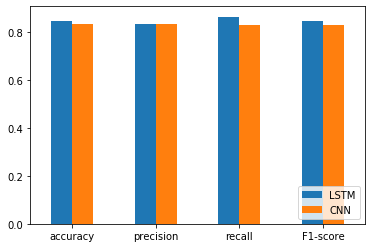

In [36]:
LSTM_metrics = np.array([LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1_score])
CNN_metrics = np.array([CNN_accuracy, CNN_precision, CNN_recall, CNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'LSTM': LSTM_metrics,'CNN': CNN_metrics }, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

# ROC Curve

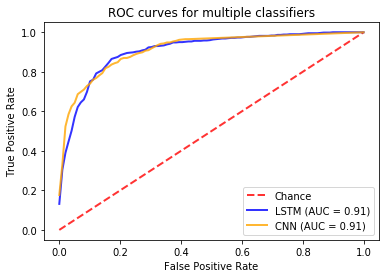

In [37]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, LSTM_tpr[0,:], lw=2, color='blue', label='LSTM (AUC = %0.2f)' % (LSTM_auc), alpha=0.8)
plt.plot(mean_fpr, CNN_tpr[0,:], lw=2, color='orange', label='CNN (AUC = %0.2f)' % (CNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

It is found out that LSTM shows a high performance measures when combined with Word2vec